In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from env_utils import PDUSession
from nfv_allocation_cpu_env import NfvAllocEnv
from nfv_allocation_cpu_env_duration import NfvAllocEnvDuration
from nfv_allocation_cpu_env_rew import NfvAllocEnvRew
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from sb3_contrib import MaskablePPO, RecurrentPPO

2024-07-18 10:55:18.465596: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-18 10:55:18.467385: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-18 10:55:18.492913: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 10:55:18.492937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 10:55:18.493581: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
#qi_dict = {3:0.6, 5:0.3, 9:0.1}
qi_dict = {3:0.3, 5:0.4, 9:0.3}
qi_dict = {3:1.0}
env_pars_power={'config_file': 'synth3_host_models.json', 'obs_metric':'power', 'rw_metric':'power', 'flat_lerr': True, 'dt_scale': 1.5, 'duration_mean':40, 'duration_scale':5, 'qi_dict': qi_dict}
env_pars_cpu={'config_file': 'synth3_host_models.json', 'obs_metric':'cpu', 'rw_metric':'power', 'flat_lerr': True, 'dt_scale': 1.5, 'duration_mean':40, 'duration_scale':5, 'qi_dict': qi_dict}
#seed = 10
gamma = 0.05
n_steps = 1_000
#test_dts = [1.0, 1.5, 2.0]
test_dts = [1.5, 2.0, 2.5, 3.0]
test_seeds = [10,11,12,13]

envp = DummyVecEnv([lambda: NfvAllocEnvRew(**env_pars_power)])
envp = VecNormalize(envp, norm_reward=False) 

envc = DummyVecEnv([lambda: NfvAllocEnvRew(**env_pars_cpu)])
envc = VecNormalize(envc, norm_reward=False) 

envs=[envp,envc]

f = open('5qi_table.json')
qi_table = json.load(f)

models = ["PPO_rew10_net128_scale1.5_env8_synth3_power_qi3_p1",
          "PPO_rew10_net128_scale1.5_env8_synth3_cpu_qi3_p1"]

#models = ["PPO_rew_net128_scale1.5_env8_nuc_power_llearn_flat_npseedNone_g05_qi359_p343",
#         "PPO_rew_net128_scale1.5_env8_nuc_cpu_llearn_flat_npseedNone_g05_qi359_p343"]

labels=['Power consumption', 'CPU utilization']

In [3]:
#obs, info = env.reset(seed=seed)
#print(obs.shape)
#print(obs)
#path = f'saved models/PPO_scale1.5_env8_synth_power_seed1_g05_qi359_p631'
#m = MaskablePPO.load(path)
#ve=m.get_vec_normalize_env()
#print(ve)

In [4]:
step_data = []
run_data = []
choices = []

for seed in tqdm(test_seeds):

    for dt in tqdm(test_dts):
    
        for i, model in enumerate(tqdm(models, leave=True)):
        
            path = f'saved models/{model}'
            
            drl_model = MaskablePPO.load(path)
        
            env=envs[i]
            #env.set_dt_scale(dt)
            env.env_method("set_dt_scale", dt)
            env.seed(seed)
            obs = env.reset()
            
            drl_lat_errors = []
            drl_rewards = []
            
            for step in tqdm(range(n_steps), leave=True):
                mask = np.array(env.env_method("action_masks"))
                action = drl_model.predict(obs, action_masks=mask)
                qi= env.env_method("get_current_qi")
                choices.append([labels[i], int(qi[0]), int(action[0])])
                obs, reward, dones, info = env.step(action)
                drl_lat_errors.append(info[0]['latency_error'])
                drl_rewards.append(reward[0])
                step_data.append([seed, labels[i], dt, step, info[0]['power_per_mbit']])
            
            run_data.append([seed, labels[i], dt, np.mean(drl_rewards), np.count_nonzero(drl_lat_errors)/n_steps*100] )
        
step_df = pd.DataFrame(step_data, columns=['seed', 'model', 'dt', 'step','power'])
run_df = pd.DataFrame(run_data, columns=['seed', 'model', 'dt', 'reward', 'error percent'])
choices_df = pd.DataFrame(choices, columns=['metric','5qi', 'host'])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_14874/2381427308.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  choices.append([labels[i], int(qi[0]), int(action[0])])


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
palette=['black','c','deeppink','orange']
palette = ['lime','dodgerblue']
palette = ['lightgreen', 'lightskyblue']

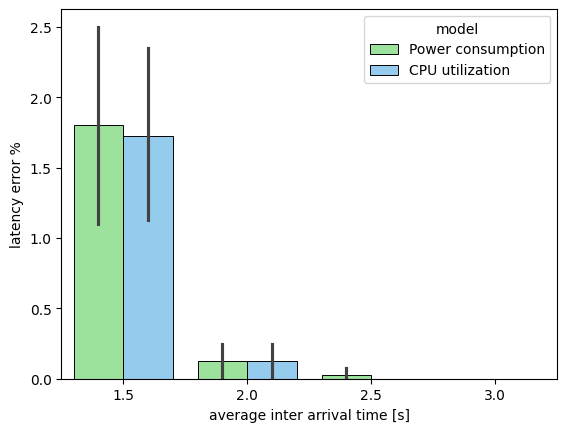

In [6]:
sns.barplot(data=run_df, y='error percent', x='dt', hue='model', palette=palette, linewidth=.7, edgecolor="0")
plt.ylabel("latency error %")
plt.xlabel("average inter arrival time [s]")
labs = ["scale1.5_cpu","scale1.5_power","scale1_cpu","scale1_power"]
#plt.legend( loc=6, prop={'size': 8})
#plt.grid()
plt.show()

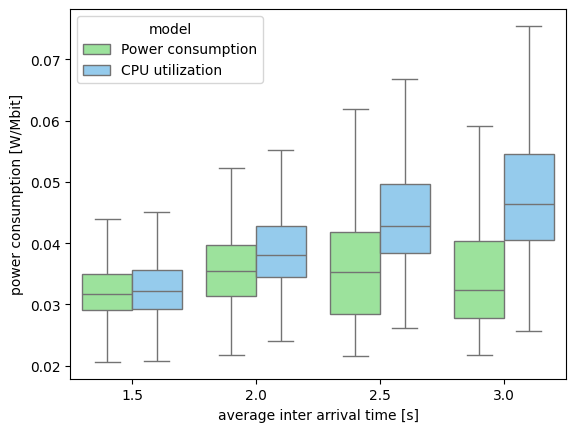

In [7]:
sns.boxplot(data=step_df, y="power", x='dt', hue="model", showfliers=False, palette=palette)
plt.ylabel("power consumption [W/Mbit]")
plt.xlabel("average inter arrival time [s]")
#plt.grid()
plt.show()

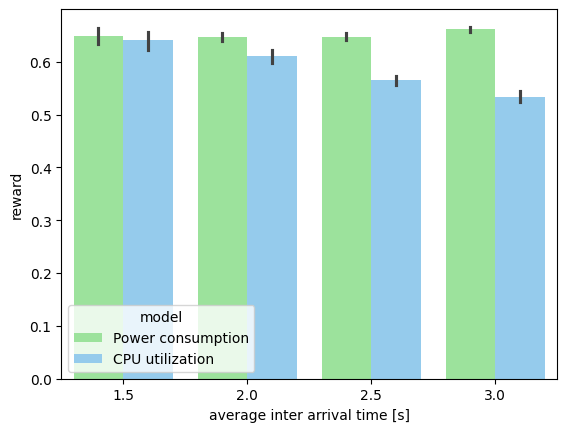

In [8]:
sns.barplot(data=run_df, y='reward', x='dt', hue='model', palette=palette)
plt.ylabel("reward")
plt.xlabel("average inter arrival time [s]")
labs = ["scale1.5_cpu","scale1.5_power","scale1_cpu","scale1_power"]
#plt.legend( loc=6, prop={'size': 8})
#plt.grid()
plt.show()

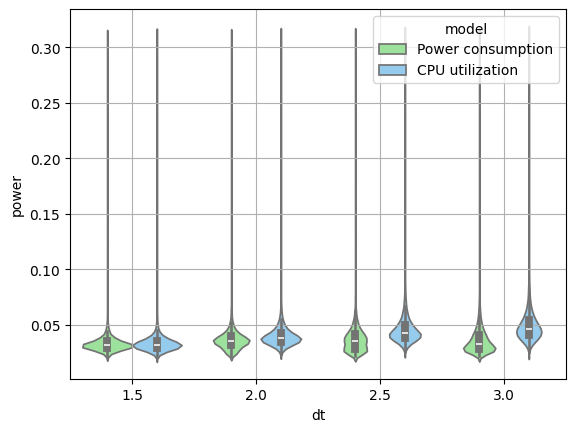

In [9]:
sns.violinplot(data=step_df, y="power", x='dt', hue="model", palette=palette)
#plt.ylim(0.01, 0.1)
plt.grid()
#plt.legend(prop={'size': 8})

Text(0.5, 1.0, 'CPU utilization')

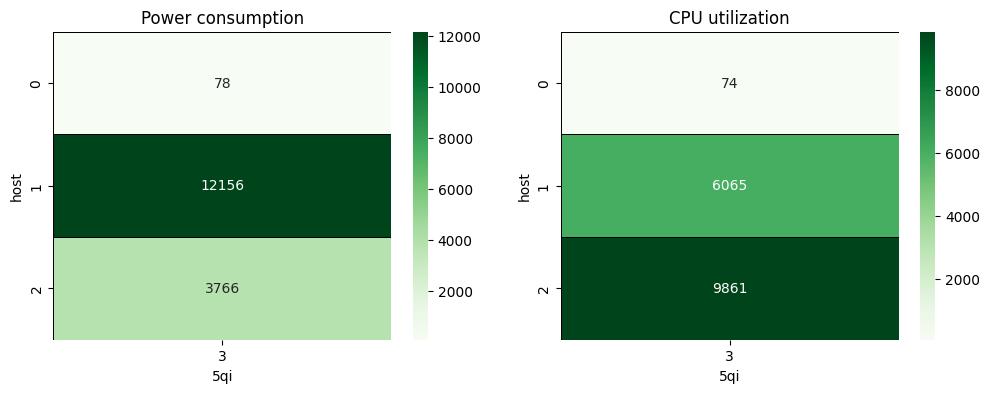

In [10]:
ccp = choices_df.loc[choices_df['metric'] == labels[0]]
ccc = choices_df.loc[choices_df['metric'] == labels[1]]
cdf_p = pd.crosstab(ccp['host'], ccp['5qi'])#.div(len(choices_df))
cdf_c = pd.crosstab(ccc['host'], ccc['5qi'])#.div(len(choices_df))

f, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(cdf_p, annot=True, fmt='g',cmap="Greens", linewidths=.5, linecolor='0', ax=axes[0]).set_title(labels[0])
sns.heatmap(cdf_c, annot=True, fmt='g',cmap="Greens", linewidths=.5, linecolor='0', ax=axes[1]).set_title(labels[1])